PARA UTILIZAR GPU:

Presiona Entorno de ejecución o Runtime, luego en cambiar tipo. Ahí seleccionan GPU.

In [1]:
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/data"
LABEL_MAP = {"benign": 0, "malignant": 1}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_set_images = []
data_set_labels = []

for label, value in LABEL_MAP.items():
    label_path = os.path.join(DATA_DIR, label)

    if not os.path.isdir(label_path):
        print(f"{label_path} (no es carpeta)")
        continue

    for file in os.listdir(label_path):
        if file.lower().endswith('.jpg'):
            file_path = os.path.join(label_path, file)
            image = cv2.imread(file_path)

            if image is None:
              print(f"Error cargando {file_path}")
              continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data_set_images.append(image)
            data_set_labels.append(value)


data_set_images = np.array(data_set_images)
data_set_labels = np.array(data_set_labels)

total_benign = np.sum(data_set_labels == LABEL_MAP["benign"])

print(f"Total de datos cargados: {len(data_set_images)}")
print(f"benigno: {total_benign}")
print(f"malignano: {len(data_set_images) - total_benign}")

Total de datos cargados: 10605
benigno: 5500
malignano: 5105


Train: 8484
Benigno: 4400, Malignano: 4084
Test: 2121
Benigno: 1100, Malignano: 1021


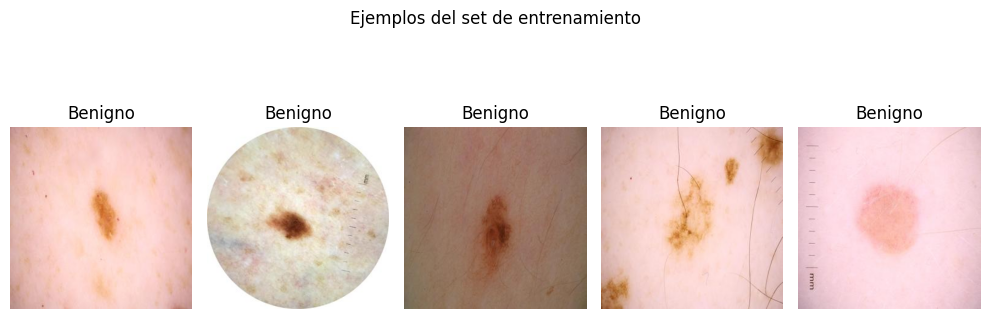

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    data_set_images,
    data_set_labels,
    test_size=0.2,
    stratify=data_set_labels, #importante para mantener la proporción de clases
    random_state=42
)

print(f"Train: {len(x_train)}")
print(f"Benigno: {np.sum(y_train==LABEL_MAP['benign'])}, Malignano: {np.sum(y_train==LABEL_MAP['malignant'])}")
print(f"Test: {len(x_test)}")
print(f"Benigno: {np.sum(y_test==LABEL_MAP['benign'])}, Malignano: {np.sum(y_test==LABEL_MAP['malignant'])}")

def show_sample(images, labels, title=""):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        idx = np.random.randint(0, len(images))
        plt.subplot(1, 5, i+1)
        plt.imshow(images[idx])
        plt.title("Benigno" if labels[idx]==LABEL_MAP['benign'] else "Malignano")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_sample(x_train, y_train, title="Ejemplos del set de entrenamiento")

In [5]:
def compute_mean_std(images):
    n_images = len(images)
    channel_sum = np.zeros(3)
    channel_squared_sum = np.zeros(3)
    total_pixels = 0

    for img in images:
        img = img.astype(np.float32) / 255.0  # Normalizar a [0,1]
        h, w, c = img.shape
        total_pixels += h * w

        # Sumar por canal
        channel_sum += img.sum(axis=(0, 1))
        channel_squared_sum += (img ** 2).sum(axis=(0, 1))

    mean = channel_sum / total_pixels
    std = np.sqrt(channel_squared_sum / total_pixels - mean ** 2)
    return mean, std

mean_train, std_train = compute_mean_std(x_train)
print("Media y desviación estándar del set de entrenamiento:")
print("Mean:", mean_train)
print("Std:", std_train)

print("Media y desviación estándar del set de test:")
mean_test, std_test = compute_mean_std(x_test)
print("Mean:", mean_test)
print("Std:", std_test)

Media y desviación estándar del set de entrenamiento:
Mean: [0.71541243 0.56651784 0.54383255]
Std: [0.22411748 0.21254406 0.22671607]
Media y desviación estándar del set de test:
Mean: [0.71818791 0.56801524 0.54509681]
Std: [0.22244352 0.21151681 0.22544196]


In [6]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class MoleDataset(Dataset):
    def __init__(self, images, labels, mean, std, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment

        # Transformaciones base (resize + normalización)
        base_transform = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ]

        # Augmentación solo para entrenamiento
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                *base_transform
            ])
        else:
            self.transform = transforms.Compose(base_transform)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = self.transform(image)
        return image, label

In [7]:
train_dataset = MoleDataset(x_train, y_train, augment=True, mean=mean_train, std=std_train)
test_dataset  = MoleDataset(x_test, y_test, augment=False, mean=mean_test, std=std_test)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
class MLPDetector(nn.Module):
  def __init__(self, features_n):
    super().__init__()
    self.flatten = nn.Flatten()
    self.hidden1 = nn.Linear(features_n, features_n//2)
    self.output = nn.Linear(features_n//2, 1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.hidden(x)
    x = nn.ReLU()(x)
    x = self.output(x)
    x = nn.Sigmoid(x)
    return x

In [9]:
class StepByStep(object):
  def __init__(self, model, loss_fn, optimizer):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.model.to(self.device)

    self.train_loader = None
    self.val_loader = None

    self.losses = []
    self.val_losses = []
    self.total_epochs = 0

    self.train_step_fn = self._make_train_step_fn()

  def to(self, device):
    try:
      self.device = device
      self.model.to(self.device)

    except RuntimeError:
      self.device = ('cuda' if torch.cuda.is_available()
      else 'cpu')
      print(f"Couldn't send it to {device}, \
      sending it to {self.device} instead.")
      self.model.to(self.device)

  def set_loaders(self, train_loader, val_loader):
    self.train_loader = train_loader
    self.val_loader = val_loader

  def _make_train_step_fn(self):
    def perform_train_step_fn(x, y):
      self.model.train()
      yhat = self.model(x)
      loss = self.loss_fn(yhat, y)
      loss.backward()

      self.optimizer.step()
      self.optimizer.zero_grad()

      return loss.item()

    return perform_train_step_fn

  def _make_val_step_fn(self):
    def perform_val_step_fn(x, y):
      self.model.eval()
      yhat = self.model(x)
      loss = self.loss_fn(yhat, y)
      return loss.item()

    return perform_val_step_fn

  def _mini_batch(self, validation=False):
    if validation:
      data_loader = self.val_loader
      step_fn = self.val_step_fn
    else:
      data_loader = self.train_loader
      step_fn = self.train_step_fn

    if data_loader is None:
      return None

    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
      x_batch = x_batch.to(self.device)
      y_batch = y_batch.to(self.device)

      mini_batch_loss = step_fn(x_batch, y_batch)
      mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

  def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

  def train(self, n_epochs, seed=42):
    self.set_seed(seed)
    for epoch in range(n_epochs):
      self.total_epochs += 1
      loss = self._mini_batch(validation=False)
      self.losses.append(loss)
      with torch.no_grad():
        # Performs evaluation using mini-batches
        val_loss = self._mini_batch(validation=True)
        self.val_losses.append(val_loss)
      # If a SummaryWriter has been set...
        if self.writer:
          scalars = {'training': loss}
          if val_loss is not None:
            scalars.update({'validation': val_loss})

          self.writer.add_scalars(main_tag='loss',
                                  tag_scalar_dict=scalars,
                                  global_step=epoch)
      if self.writer:
        self.writer.flush()
  def save_checkpoint(self, filename):
    checkpoint = {
      'epoch': self.total_epochs,
      'model_state_dict': self.model.state_dict(),
      'optimizer_state_dict': self.optimizer.state_dict(),
      'loss': self.losses,
      'val_loss': self.val_losses
    }

    torch.save(checkpoint, filename)
  def load_checkpoint(self, filename):
    checkpoint = torch.load(filename)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(
      checkpoint['optimizer_state_dict']
    )
    self.total_epochs = checkpoint['epoch']
    self.losses = checkpoint['loss']
    self.val_losses = checkpoint['val_loss']
    self.model.train()

  def predict(self, x):
    self.model.eval()
    x_tensor = torch.as_tensor(x).float()
    y_hat_tensor = self.model(x_tensor.to(self.device))
    self.model.train()
    return y_hat_tensor.detach().cpu().numpy()

  def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label='Training Loss', c='b')

    if self.val_loader:
      plt.plot(self.val_losses, label='Validation Loss', c='r')

    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

In [ ]:
model = MLPDetector(features_n=3*224*224)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, test_loader)
sbs.set_tensorboard('classy')

sbs.set_loaders(train_loader, test_loader)
sbs.train(n_epochs=10)
sbs.plot_losses()
